In [ ]:
%cd mgh/data

[Errno 2] No such file or directory: 'mgh/data'
/home/rene/notebooks/mgh/data


### Control coefficients

In [ ]:
DEBUG=True # To control debug msg during training
PRINT=True

DELTA_FEATURES=False # Create delta features in the dataset (delta of one feature between two timepoints)
STANDARD_SCALE=False # Use a StandardScaler for normalizing the feature

MAX_TRIALS = 75 # How many hyperopt tuples to test before deciding the (locally) optimal one

Y_INTEREST = ["CFuture" + str(_) for _ in range(1,5)] # The CFutures we're interested in

### Imports & IPython Settings

In [ ]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from hyperopt.mongoexp import MongoTrials

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sklearn.neighbors
from xgboost import XGBRegressor

In [ ]:
%matplotlib inline

### Global helper functions

In [ ]:
import math
def plot_trend(classifier, X_test, y_test_, model, split, lbl):
    yhat = classifier.predict(X_test)
    mape = mean_absolute_percentage_error(y_test_,yhat)
    rmse = math.sqrt(mean_squared_error(y_test_, yhat))
    fig = plt.figure(figsize=(15,8))
    plt.plot(y_test_, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.legend()
    plt.title(f'RMSE: {np.round(rmse,4)}, MAPE: {np.round(mape,4)}')
    plt.gca().set_xlabel("Days")
    plt.gca().set_ylabel(lbl)
    plt.gcf().set_figwidth(7)
    plt.gcf().set_figheight(4)
    fig.savefig(model + '_' + lbl + '_split_' + str(split) + '.pdf')
    return plt

### Preprocessing, Metrics & Objective Functions

In [ ]:
def metric_mape(estimator, X, y): #ypred, dtest):
   labels = estimator.predict(X)
   return mean_absolute_percentage_error(labels,y) #np.mean(np.abs((labels - y) / labels) * 100) #('MAPE (%)', )
def metric_mse(estimator, X, y): #ypred, dtest):
   labels = estimator.predict(X)
   return mean_squared_error(labels, y)

In [ ]:
def preprocess(X_train, transformers):
    X_train = X_train.copy()
    scaler = transformers.get("sscaler", None)
    if DELTA_FEATURES:
        deltas_ = X_train.loc[:, [_ for _ in X_train.columns if not _ in exclude]].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
        for _ in range(DELTA_FEATURES - 1):
            X_train = pd.concat([X_train, deltas_.fillna(method="backfill")], axis=1)
            deltas_ = deltas_.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
        X_train = pd.concat([X_train, deltas_.fillna(method="backfill")], axis=1)

    if STANDARD_SCALE:
        exclude = ["YearDayNum"]
        if not scaler:
            scaler = sklearn.preprocessing.StandardScaler()
            X_train.loc[:, [_ for _ in X_train.columns if not _ in exclude]] = scaler.fit_transform(X_train.loc[:, [_ for _ in X_train.columns if not _ in exclude]])
        else:
            X_train.loc[:, [_ for _ in X_train.columns if not _ in exclude]] = scaler.transform(X_train.loc[:, [_ for _ in X_train.columns if not _ in exclude]])

    return X_train, {'sscaler' : scaler}

In [ ]:
def custom_cv_2folds(X_train, X_valid):
    ntrain = X_train.shape[0]
    nvalid = X_valid.shape[0]
    #print('Training samples: '+str(ntrain)+'\n')
    #print('Validation samples: '+str(nvalid)+'\n')

    idx_train = np.arange(0, ntrain, dtype=int)
    idx_valid = np.arange(ntrain, ntrain+nvalid, dtype=int)
    yield idx_train, idx_valid

In [ ]:
def xgb_objective(space):
    classifier = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    #classifier.fit(X_train, y_train_)
    X_train_valid = np.concatenate([X_train,X_valid])
    y_train_valid_ = np.concatenate([y_train_,y_valid_])
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train_valid, y = y_train_valid_, cv=custom_cv_2folds(X_train, X_valid), scoring=metric_mape)
    CrossValMean = accuracies.mean()

    return{'loss':CrossValMean, 'status': STATUS_OK }

In [ ]:
def linear_regression_objective(space):
    classifier = sklearn.linear_model.LinearRegression(**space)
    #classifier.fit(X_train, y_train_)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train_, cv=sklearn.model_selection.TimeSeriesSplit(n_splits=3).split(X_train), scoring=metric_mape)
    CrossValMean = accuracies.mean()

    return{'loss':CrossValMean, 'status': STATUS_OK }

In [ ]:
def kneighbour_objective(space):
    classifier = sklearn.neighbors.KNeighborsRegressor(**space)
    #classifier.fit(X_train, y_train_)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train_, cv=sklearn.model_selection.TimeSeriesSplit(n_splits=3).split(X_train), scoring=metric_mape)
    CrossValMean = accuracies.mean()

    return {'loss':CrossValMean, 'status': STATUS_OK }

In [ ]:
def lin_svr_objective(space):
    classifier = sklearn.svm.SVR(**space)
    #classifier.fit(X_train, y_train_)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train_, cv=sklearn.model_selection.TimeSeriesSplit(n_splits=3).split(X_train), scoring=metric_mape)
    CrossValMean = accuracies.mean()

    return {'loss':CrossValMean, 'status': STATUS_OK }

In [ ]:
#kernel='', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1

In [ ]:
import time
def fit_evaluate_regressor(archi, X_, y_, Xt_, yt_, results={}, exp="exp1"):
    def trialme(objective, space):
        trials = Trials() #MongoTrials('mongo://localhost:27017/mgh_db/jobs', exp_key=exp)

        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=MAX_TRIALS,
                    trials=trials)
        #print("Best: ", best)
        return [space_eval(space, best), trials]

    timee = time.time()
    obj_func = globals()[archi + "_objective"]

    if archi == "lin_svr":
        space = {
            'C': hp.uniform('C', 0, 20),
            'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
            'gamma': hp.choice('gamma', ["scale", "auto"]),
            'degree': hp.choice('degree', range(2,5)),
            'C': hp.uniform('C',0, 100),
            'coef0': hp.uniform('coef0',0, 100),
        }
        classifier = sklearn.svm.SVR

    elif archi == "kneighbour":
        space = {
            'n_neighbors': hp.quniform('n_neighbors',1,100,1), #hp.choice('n_neighbors', range(1,50)),
            'weights': hp.choice('weights',['uniform','distance']),
            'algorithm': hp.choice('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': hp.quniform('leaf_size',1,50,1),
            'metric': hp.choice('metric',['minkowski','mahalanobis','chebyshev','seuclidean']),
            'p': hp.quniform('p',1,15,1),
        }
        classifier = sklearn.neighbors.KNeighborsRegressor

    elif archi == "linear_regression":
        space = {
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'normalize' : hp.choice('normalize', [True, False]) }

        # Fitting XGBoost to the Training set
        classifier = sklearn.linear_model.LinearRegression

    elif archi == "xgb":
        space = {
            'max_depth' : hp.choice('max_depth', range(3, 5, 1)),
            'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
            'n_estimators' : hp.choice('n_estimators', range(20, 70, 10)),
            'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
            'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
            'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

        # Fitting XGBoost to the Training set
        classifier = XGBRegressor


    results[archi] = trialme(obj_func, space)
    classifier = classifier(**results[archi][0])
    classifier.fit(X_, y_)

    mape = metric_mape(classifier, Xt_, yt_)
    mse = metric_mse(classifier, Xt_, yt_)

    results[archi].extend([classifier, mape, mse])
    print(archi, ":", "MSE:", mse, "MAPE:", mape)
    print(archi, "took", time.time() - timee, "seconds.")

### Data Import, Preprocessing & Model Training

In [ ]:
X_train, y_train, X_test, y_test = None, None, None, None
y_train_ = None
y_test_ = None

In [ ]:
# import the data (all features)
split = 4
X_train = pd.read_csv('X_train_wf_split_'+str(split)+'.csv'); X_test = pd.read_csv('X_test_wf_split_'+str(split)+'.csv');
X_valid = pd.read_csv('X_valid_wf_split_'+str(split)+'.csv')
y_train = pd.read_csv('y_train_wf_split_'+str(split)+'.csv'); y_test = pd.read_csv('y_test_wf_split_'+str(split)+'.csv');
y_valid = pd.read_csv('y_valid_wf_split_'+str(split)+'.csv')
print(['Size train set: ',len(X_train)]);
print(['Size test set: ',len(X_test)]);
#X_train.head()

['Size train set: ', 229]
['Size test set: ', 56]


In [ ]:
X_train= X_train.infer_objects()
X_test = X_test.infer_objects()
X_valid = X_valid.infer_objects()

In [ ]:
X_train, transformers = preprocess(X_train, {})
X_valid, _ = preprocess(X_valid, transformers)
X_test, _ = preprocess(X_test, transformers)

In [ ]:
# hyperparam opt - evaluate on CV set and print MAPE/RMSE using best settings on CV set
warnings.filterwarnings(action= 'ignore')
archis = [ "xgb", "kneighbour", "linear_regression", "lin_svr"]
#archis = [ "lin_svr"]
archis = ["xgb"] #[ "kneighbour", "linear_regression", "xgb"]#, "xgb"]

all_results = {}
for _y in Y_INTEREST:
    y_train_ = y_train[_y].values
    y_valid_ = y_valid[_y].values
    all_results[_y] = {}
    print("============= %s =============" % _y)
    for _archi in archis:
        print("##",_archi,"::")
        results = {}
        #fit_evaluate_regressor(archi, X_, y_, Xt_, yt_, results={}, exp="exp1"):
        fit_evaluate_regressor(_archi, X_train, y_train_, X_valid, y_valid_, results=results, exp=_y + "_exp9" + ("_" + _archi if _archi != "xgb" else ""))
        all_results[_y].update(results)
    print("")
    print("")

============= CFuture1 =============
## xgb ::
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:51] WARNING: /workspace/src/objective/regression_obj.cu:1

In [ ]:
all_results

{'CFuture1': {'xgb': [{'colsample_bytree': 1.0,
    'gamma': 0.26,
    'learning_rate': 0.35000000000000003,
    'max_depth': 3,
    'min_child_weight': 8.0,
    'n_estimators': 60,
    'subsample': 0.81},
   XGBRegressor(colsample_bytree=1.0, gamma=0.26,
                learning_rate=0.35000000000000003, min_child_weight=8.0,
                n_estimators=60, subsample=0.81),
   0.04771852938228826,
   4975.738224330491]},
 'CFuture2': {'xgb': [{'colsample_bytree': 0.73,
    'gamma': 0.25,
    'learning_rate': 0.39,
    'max_depth': 4,
    'min_child_weight': 10.0,
    'n_estimators': 60,
    'subsample': 0.62},
   XGBRegressor(colsample_bytree=0.73, gamma=0.25, learning_rate=0.39, max_depth=4,
                min_child_weight=10.0, n_estimators=60, subsample=0.62),
   0.04427115444096691,
   15103.683177467701]},
 'CFuture3': {'xgb': [{'colsample_bytree': 0.8300000000000001,
    'gamma': 0.03,
    'learning_rate': 0.15,
    'max_depth': 4,
    'min_child_weight': 8.0,
    'n_estimator

In [ ]:
#metric_mape(all_results["CFuture1"]["linear_regression"][-3], X_test, y_test_, "CFuture1")

In [ ]:
#clss = XGBRegressor(**{'colsample_bytree': 1, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.4, 'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 80, 'objective': 'reg:squarederror'})
#clss.fit(X_train, y_train["CFuture1"])

In [ ]:
# save results
import pickle
y_hat_test = all_results[key]["xgb"][2].predict(X_test)
y_hat_valid = all_results[key]["xgb"][2].predict(X_valid)
# Example file name: xgb_cfuture1__testing_covid.pkl
with open('xgb_cfuture_'+ key+'__split_'+ str(split) + '_data-normal.pkl', "wb") as file_:
	pickle.dump([
      model,
      X_valid,
      y_hat_valid, # the predicted y value for CFutureX (X= 1-4) valid set
      y_valid, # the ground-truth y value
      X_test,
      y_hat_test,
      y_test,
      all_results
      ], file_)

### Model Evaluation & Plotting

In [ ]:
key = "CFuture1"
str(all_results[key]["xgb"][0])
all_results[key]["xgb"][2]

XGBRegressor(colsample_bytree=0.96, gamma=0.36, learning_rate=0.4, max_depth=4,
             min_child_weight=2.0, n_estimators=30, subsample=0.44)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

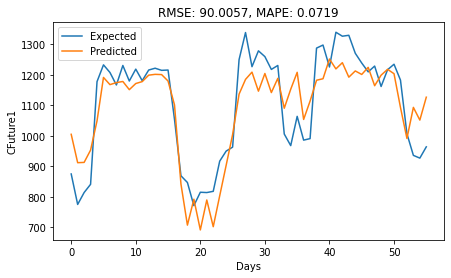

In [ ]:
key = "CFuture1";  model="xgb"
plot_trend(all_results[key]["xgb"][2], X_test, y_test[key], model, split, key)

**COVID Check**

In [ ]:
df = pd.read_excel('ModelData_Cleaned.xlsx')
data_covid = df[df['Date'] > '2020-02-01'][0:80] # cut off the data points > 80 or after 26-520 (as they're inaccurate)
data_covid = data_covid.drop(labels=["Date",'CWeekDay','CCoronaRelDateNum','CCoronaRelWeekNum','CWeekNumYear'],axis=1)
data_covid.head()
X_test_covid = data_covid.drop(labels=["CFuture1","CFuture2","CFuture3","CFuture4"],axis=1)
y_test_covid = data_covid[["CFuture1","CFuture2","CFuture3","CFuture4"]]

In [ ]:
X_test_covid, _ = preprocess(X_test_covid, transformers)

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

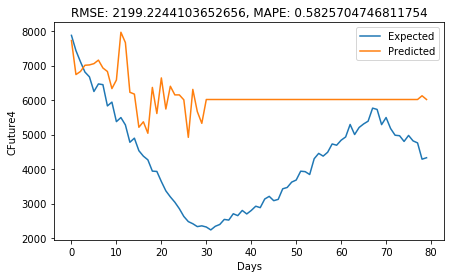

In [ ]:
key = "CFuture4"
plot_trend(all_results[key]["xgb"][2], X_test_covid.values, y_test_covid[key].values, key)

## Backup

In [ ]:
mean_absolute_error(y_test["CFuture1"], clss.predict(X_test))

68.30184064592633

In [ ]:
yhat = clss.predict(X_test)
np.mean((yhat - y_test["CFuture1"]) / (y_test["CFuture1"]))

-0.021156104370755716

In [ ]:
sklearn.linear_model.LinearRegression

In [ ]:
X_train.shape

In [ ]:
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train["CFuture1"])
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

In [ ]:
np.sin((365/2)/365 * 2* np.pi)

In [ ]:
# import the data (all features)
X_train = pd.read_csv('train_X.csv'); X_test = pd.read_csv('test_X.csv')
y_train = pd.read_csv('train_y.csv'); y_test = pd.read_csv('test_y.csv')
print(['Size train set: ',len(X_train)]);
print(['Size test set: ',len(X_test)]);
X_train.head()

['Size train set: ', 294]
['Size test set: ', 56]


,YearDayNum,NumO1,NumO2,NumO3,NumO4,NumR1,NumR2,NumR3,NumR4,NumSA1,...,NumS3,NumS4,NumC1,NumC2,NumC3,NumC4,NumSF1,NumSF2,NumSF3,NumSF4
0,282,64,70,95,134,4,9,14,22,80,...,190,188,190,387,370,375,489,887,1408,2067
1,283,55,77,104,143,4,8,23,26,67,...,179,179,177,553,569,575,484,952,1414,2153
2,284,59,92,102,140,4,6,14,22,89,...,191,202,197,728,742,773,536,917,1489,2107
3,285,49,79,92,145,7,9,18,27,83,...,198,202,195,798,941,961,551,1002,1574,2228
4,288,44,75,94,123,7,9,11,21,62,...,169,176,163,949,1111,1077,584,950,1609,2158


In [ ]:
DELTA_FEATURES=True
STANDARD_SCALE=True

In [ ]:
X_train= X_train.infer_objects()
X_test = X_test.infer_objects()

In [ ]:
X_train, transformers = preprocess(X_train, {})
X_test, _ = preprocess(X_test, transformers)

In [ ]:
def metric_mape(estimator, X, y): #ypred, dtest):
   labels = estimator.predict(X)
   return mean_absolute_percentage_error(labels,y) #np.mean(np.abs((labels - y) / labels) * 100) #('MAPE (%)', )

In [ ]:
all_results = {}

In [ ]:
mapes = []
def permute_and_fit(Xtr, ytr, Xte, yte label_cls="CFuture1", funccnt=10):
    funccnt = min(funccnt, Xtr.shape[1])
    funcs = [np.,np.log, lambda x: np.power(x,2), lambda x: np.power(x,3), lambda x: np.power(x, 0.5), lambda x: np.power(x,1./3.)]
    for _funccnt in range(funccnt):
        for _seq in itertools.combinations(range(Xtr.shape[1]), _funccnt):
            Xtr_ = np.copy(Xtr)
            Xte_ = np.copy(Xte)
            for _elem in _seq:
                for _func in funcs:
                    Xte_ = np.hstack([Xte_, _func(Xte_[:,_elem])])
                    Xtr_ = np.hstack([Xtr_, _func(Xtr_[:,_elem])])
            clas = sklearn.linear_model.LinearRegression(fit_intercept=True)
            clas.fit(Xtr_, ytr[label_cls])
            mapes.append([_seq, metric_mape(clas, Xte_, yte)])